In [1]:
!pip install keras
!pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [47]:
df=pd.read_csv('data.csv')
idx=df.index.values
df=df[::-1]
df.index=idx

In [48]:
df.head()

,Ngày,Giá điều chỉnh,Giá đóng cửa,Thay đổi,Khối lượng khớp lệnh,Giá trị khớp lệnh,KL thoả thuận,GT thoả thuận,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,03/01/2017,13.37,44.85,0.85(1.93 %),1013070,45364000000,0,0,44.85,44.95,44.30
1,04/01/2017,13.49,45.25,0.4(0.89 %),1022560,46307000000,0,0,44.80,45.70,44.70
2,05/01/2017,13.45,45.10,-0.15(-0.33 %),613870,27765000000,525952,23228576800,45.20,45.40,45.10
3,06/01/2017,13.40,44.95,-0.15(-0.33 %),799750,36146000000,274750,13256687500,45.20,45.50,44.95
4,09/01/2017,13.48,45.20,0.25(0.56 %),501610,22656000000,115952,5449493600,45.05,45.40,44.90


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 1735 to 0
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ngày                  1736 non-null   object 
 1   Giá điều chỉnh        1736 non-null   float64
 2   Giá đóng cửa          1736 non-null   float64
 3   Thay đổi              1736 non-null   object 
 4   Khối lượng khớp lệnh  1736 non-null   int64  
 5   Giá trị khớp lệnh     1736 non-null   int64  
 6   KL thoả thuận         1736 non-null   int64  
 7   GT thoả thuận         1736 non-null   int64  
 8   Giá mở cửa            1736 non-null   float64
 9   Giá cao nhất          1736 non-null   float64
 10  Giá thấp nhất         1736 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 149.3+ KB


In [50]:
data=df.drop(columns=['Ngày','Thay đổi'])

In [51]:
data.corr().style.background_gradient(cmap='coolwarm')


,Giá điều chỉnh,Giá đóng cửa,Khối lượng khớp lệnh,Giá trị khớp lệnh,KL thoả thuận,GT thoả thuận,Giá mở cửa,Giá cao nhất,Giá thấp nhất
Giá điều chỉnh,1.000000,0.926902,0.247869,0.504974,0.202133,0.307973,0.926361,0.925315,0.927186
Giá đóng cửa,0.926902,1.000000,0.346237,0.617915,0.222638,0.341994,0.998405,0.999307,0.999055
Khối lượng khớp lệnh,0.247869,0.346237,1.000000,0.918841,0.175269,0.218723,0.340207,0.356145,0.331069
Giá trị khớp lệnh,0.504974,0.617915,0.918841,1.000000,0.224319,0.313680,0.612374,0.626400,0.604510
KL thoả thuận,0.202133,0.222638,0.175269,0.224319,1.000000,0.949068,0.225316,0.225231,0.221311
GT thoả thuận,0.307973,0.341994,0.218723,0.313680,0.949068,1.000000,0.345221,0.345001,0.340215
Giá mở cửa,0.926361,0.998405,0.340207,0.612374,0.225316,0.345221,1.000000,0.999174,0.999323
Giá cao nhất,0.925315,0.999307,0.356145,0.626400,0.225231,0.345001,0.999174,1.000000,0.998943
Giá thấp nhất,0.927186,0.999055,0.331069,0.604510,0.221311,0.340215,0.999323,0.998943,1.000000


In [52]:
data=data.drop(columns=['Khối lượng khớp lệnh','KL thoả thuận','GT thoả thuận'])

In [53]:
data

,Giá điều chỉnh,Giá đóng cửa,Giá trị khớp lệnh,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,13.37,44.85,45364000000,44.85,44.95,44.30
1,13.49,45.25,46307000000,44.80,45.70,44.70
2,13.45,45.10,27765000000,45.20,45.40,45.10
3,13.40,44.95,36146000000,45.20,45.50,44.95
4,13.48,45.20,22656000000,45.05,45.40,44.90
...,...,...,...,...,...,...
1731,94.20,94.20,164616000000,94.30,95.10,93.50
1732,95.00,95.00,148856000000,95.50,95.70,94.60
1733,96.80,96.80,393398000000,95.40,96.80,95.30
1734,95.20,95.20,206460000000,97.40,97.40,95.20


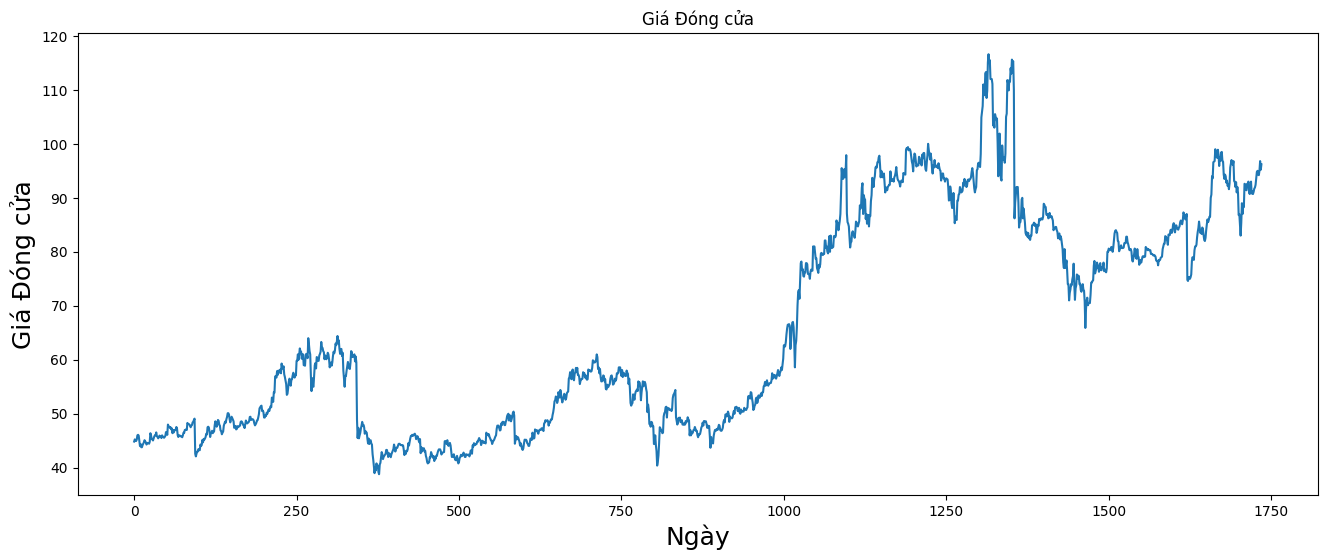

In [59]:
plt.figure(figsize=(16,6))
plt.title('Giá Đóng cửa')
plt.plot(data_close)
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá Đóng cửa', fontsize=18)
plt.show()

In [54]:
data_close = df.filter(['Giá đóng cửa'])
# Convert the dataframe to a numpy array
dataset = data_close.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))


In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0777635 ],
       [0.08290488],
       [0.08097686],
       ...,
       [0.74550129],
       [0.72493573],
       [0.7377892 ]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1590/1590 [==============================] - 74s 45ms/step - loss: 0.0023
Epoch 2/5
1590/1590 [==============================] - 72s 45ms/step - loss: 0.0012
Epoch 3/5
1590/1590 [==============================] - 72s 45ms/step - loss: 9.6764e-04
Epoch 4/5
1590/1590 [==============================] - 72s 45ms/step - loss: 7.2208e-04
Epoch 5/5
1590/1590 [==============================] - 72s 46ms/step - loss: 7.7494e-04


In [57]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 0s 25ms/step


3.054906485741906

<ipython-input-60-1ff72f1c1e52>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


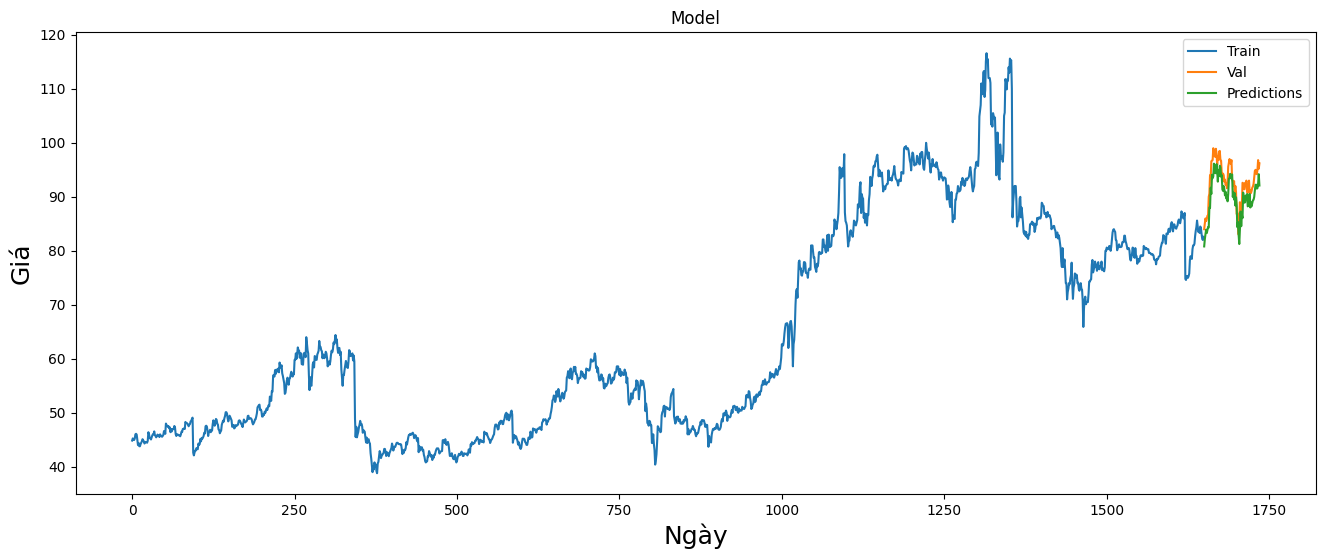

In [60]:
# Plot the data
train = data_close[:training_data_len]
valid = data_close[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá', fontsize=18)
plt.plot(train['Giá đóng cửa'])
plt.plot(valid[['Giá đóng cửa', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()


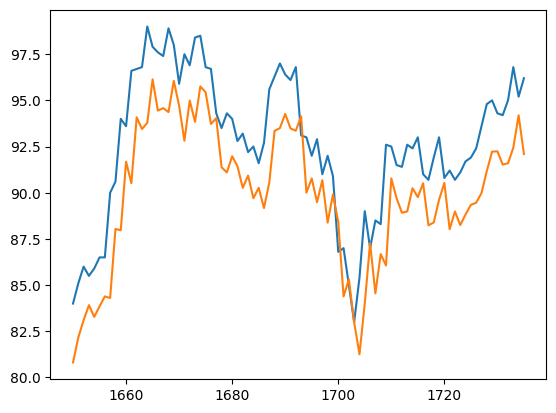

In [61]:
plt.plot(valid[['Giá đóng cửa', 'Predictions']])
